## Spam Email Classifier with KNN using TF-IDF scores

In [2]:
from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import regex as re
import numpy as np
import random
import math
   
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

### Load dataset

In [4]:
with open("SMSSpamCollection.csv",'r+') as f:
    emails = f.readlines()

### Preprocess data

In [5]:
with open("./temp.txt",'w+') as f:
    for i in range(len(emails)):
        temp = (emails[i].lower()).split('\t',1)
        temp[1] = re.sub(r"(?:\d+)(?=\D|$)", r" num ",temp[1])  # replace all numbers to num 
        temp[1] = re.sub(r'http\S+|www\S+', r' url ', temp[1])  # replace links to <url> 
        temp[1] = re.sub(r'[^\w\s]', r'', temp[1]) # remove all puntuation marks
        tokenized =  word_tokenize(temp[1])
        final_words = []
        for k in tokenized:
            if k not in stop_words: final_words.append(k)
        if(len(final_words)>0): f.write((temp[0] + '\t' + ' '.join(final_words)+'\n'))

In [6]:
with open("./temp.txt",'r+') as f:
    emails = f.readlines()

In [7]:
email_marking = []
counter = {}
words = {}
total_words = 0
for i in range(len(emails)):
    temp = (emails[i].lower()).split('\t',1)
    if(temp[0] == "spam"): email_marking.append(True)
    else: email_marking.append(False)
    tokenized =  word_tokenize(temp[1])
    for j in tokenized:
        stemmed = stemmer.stem(j.lower())
        if stemmed not in counter:
            words[total_words]=stemmed
            counter[stemmed] = {}
            counter[stemmed][i] = 1
            total_words += 1
        else:
            if i not in counter[stemmed]: counter[stemmed][i]=1
            else: counter[stemmed][i]+=1

In [8]:
sparse_matrix = np.zeros((len(emails),len(counter)))
for i in range(len(emails)):
    for j in range(len(counter)):
        if i in counter[words[j]]: 
            sparse_matrix[i][j] = counter[words[j]][i]*((len(emails))/(len(counter[words[j]])))

In [9]:
sparse_matrix

array([[  13.16548463, 5569.        ,  168.75757576, ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        5569.        , 5569.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

### Split data

In [10]:
# test - 10%, val - 10%, train - 80%
test_per = 10
val_per = 10

In [11]:
data_index = np.array([i for i in range(len(sparse_matrix))])
np.random.shuffle(data_index)
test_data_index = data_index[0:int(test_per*len(data_index)/100)]
val_data_index = data_index[1+int(test_per*len(data_index)/100):int((test_per+val_per)*len(data_index)/100)]
train_data_index = data_index[1+int((test_per+val_per)*len(data_index)/100):]

In [12]:
y_train = [email_marking[i] for i in train_data_index]
y_val = [email_marking[i] for i in val_data_index]
y_test = [email_marking[i] for i in test_data_index]

### Distance Functions 

In [13]:
matrics = set(['cosine','euclidean','manhattan','hamming'])

def cosine(list1,list2):
    list1 = np.array(list1)
    list2 = np.array(list2)
    if(len(list1)!=len(list2)): raise Exception("List length is not same in cosine distance function")
    else: return np.dot(list1,list2)/(np.linalg.norm(list1)*np.linalg.norm(list2))

def negcosine(list1,list2):
    list1 = np.array(list1)
    list2 = np.array(list2)
    if(len(list1)!=len(list2)): raise Exception("List length is not same in cosine distance function")
    else: return -np.dot(list1,list2)/(np.linalg.norm(list1)*np.linalg.norm(list2))

def euclidean(list1,list2):
    list1 = np.array(list1)
    list2 = np.array(list2)
    if(len(list1)!=len(list2)): raise Exception("List length is not same in Euclidean distance function")
    else: return np.linalg.norm(list1-list2)

def manhattan(list1,list2):
    list1 = np.array(list1)
    list2 = np.array(list2)
    if(len(list1)!=len(list2)): raise Exception("List length is not same in manhattan distance function")
    else: return np.sum(np.abs(list2-list1))

def hamming(list1,list2):
    list3 = np.array(list1).astype(dtype=bool)
    list4 = np.array(list2).astype(dtype=bool)
    if(len(list3)!=len(list4)): raise Exception("List length is not same in hamming distance function")
    else: return np.sum(np.logical_xor(list3,list4))

### Train your KNN model (reuse previously implemented model built from scratch) and test on your data

In [14]:
def knn_predict(x,y,xtest,k_neighbour=5,matric='cosine'):
    if matric not in matrics: raise Exception("Enter Correct Matric : ",matrics)
    y_pred = list()
    rev = False
    if matric == 'cosine': 
        rev = True
    for i in range(len(xtest)):
        store_distance = dict()
        for j in range(len(x)): 
            store_distance[x[j]]=globals()[matric](sparse_matrix[xtest[i]],sparse_matrix[x[j]])
        count = k_neighbour
        ham = 0
        spam = 0
        for k in sorted(store_distance.items(),key=lambda x:x[1], reverse=rev):
            count-=1
            if(email_marking[k[0]]==1): ham +=1
            else: spam +=1
            if(count==0): break
        y_pred.append(ham > spam)

    return y_pred

In [15]:
y_pred = knn_predict(train_data_index,y_train,test_data_index,k_neighbour=5,matric='cosine')
print(accuracy_score(y_test,y_pred))

0.9532374100719424


In [16]:
y_pred = knn_predict(train_data_index,y_train,test_data_index,k_neighbour=5,matric='euclidean')
print(accuracy_score(y_test,y_pred))

0.9046762589928058


In [17]:
 y_pred = knn_predict(train_data_index,y_train,test_data_index,k_neighbour=5,matric='manhattan')
 print(accuracy_score(y_test,y_pred))

0.8938848920863309


In [18]:
 y_pred = knn_predict(train_data_index,y_train,test_data_index,k_neighbour=5,matric='hamming')
 print(accuracy_score(y_test,y_pred))

0.9226618705035972


In [20]:

# First find best N using validation dataset
# then use that N on test dataset
k=[1,3,5,7,11,17,23,28]
y_pred_list = []
precision_list = []
f1_score_list = []
accuracy_list = []
recall_list = []
for i in k:
    y_pred = knn_predict(train_data_index,y_train,val_data_index,k_neighbour=i,matric='cosine')
    y_pred_list.append(y_pred)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    precision_list.append(precision_score(y_val,y_pred,average='binary'))
    recall_list.append(recall_score(y_val,y_pred,average='binary'))
    f1_score_list.append(f1_score(y_val,y_pred,average='binary'))

In [29]:
print("K : ",k,"\n")
print("precision_list : ",precision_list,"\n")
print("f1_score_list : ",f1_score_list,"\n")
print("accuracy_list : ",accuracy_list,"\n")
print("recall_list : ",recall_list,"\n")

K :  [1, 3, 5, 7, 11, 17, 23, 28] 

precision_list :  [0.8245614035087719, 0.8775510204081632, 0.9361702127659575, 0.9743589743589743, 0.975609756097561, 1.0, 0.9696969696969697, 0.9655172413793104] 

f1_score_list :  [0.746031746031746, 0.7288135593220338, 0.7586206896551724, 0.7037037037037037, 0.7272727272727274, 0.6336633663366337, 0.6274509803921569, 0.5714285714285714] 

accuracy_list :  [0.9424460431654677, 0.9424460431654677, 0.9496402877697842, 0.9424460431654677, 0.9460431654676259, 0.9334532374100719, 0.9316546762589928, 0.9244604316546763] 

recall_list :  [0.6811594202898551, 0.6231884057971014, 0.6376811594202898, 0.5507246376811594, 0.5797101449275363, 0.463768115942029, 0.463768115942029, 0.4057971014492754] 



In [21]:
k_best = np.argmax(np.array(accuracy_list))
print(f'Best K : {k_best}')
print(f'Best Accuracy : {accuracy_list[k_best]}')

Best K : 4
Best Accuracy : 0.9586330935251799


In [22]:
# Use Test dataset to check accuracy
y_pred = knn_predict(train_data_index,y_train,test_data_index,k_neighbour=k_best,matric='cosine')
print(accuracy_score(y_test,y_pred))

0.9370503597122302


***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

After rigourous experimentation we found out the following order of distance measure:
    
     Cosine > Hamming > Manhattan ~ Euclidean

- Cosine generally gave accuracy of 94-96 
- Hamming gave accuracy of 92-94
- Manhattan gave accuracy of 90-91
- Euclidean gave accuracy of about 90-91
 
Note : Since Hamming distance is only useful strins/binary data, hence we converted every **True** as **1** and every **False** as **0**, to make it a string of 0-1.

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

**Cosine** should be the best distance matrix as its purpose is in finding the document similarity in text analysis. In Cosine similarity the angle between vector is the vectors, Unlike manhattan and Euclidean which will measure the distance between tips of the vectors (which is not a good choice as consider 2 documents such that one of them will have all words present in other document but the number of words in 2nd document is more, In this case both of the documents should be similar but manhattan and will euclidean will show them different).

**Hamming** distance is used in checking distance of string, Here we are using binary strings hence the results are 2nd only to cosine distance.

**Manhattan & Euclidean** gave similar results as they are more favoured when finding distance between two points whereas here treating documents as vectors and working on angle between the 2 document vector is the key & hence gives better results, Therefore Manhattan & Eiclidean distances perform worst in our case.

***3. Report Mean Squared Error(MSE), Mean-Absolute-Error(MAE), R-squared (R2) score in a tabular form***

*Not Applicable, since this is a classification problem*

***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing R2 score vs k.***

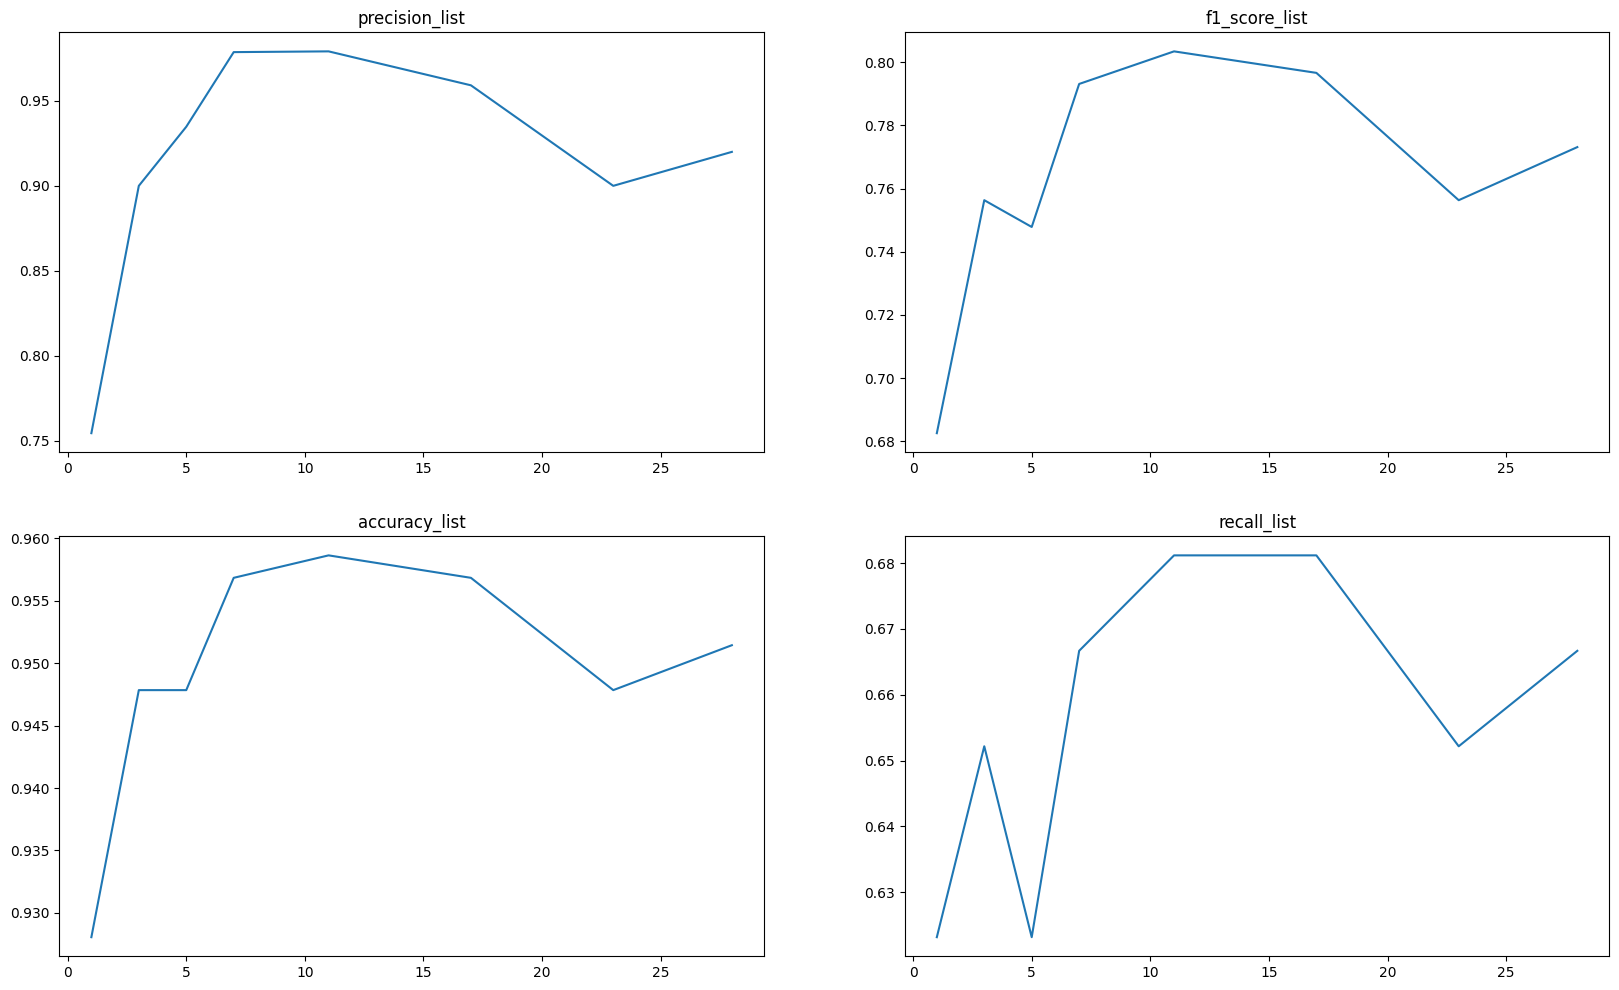

In [23]:
data = ['precision_list','f1_score_list','accuracy_list','recall_list']
fig, axs = plt.subplots(2,2,figsize=[20,12])
for i in range(2):
    for j in range(2):
        axs[i][j].set_title(data[2*i+j])
        axs[i][j].plot(k,globals()[data[2*i+j]])
plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

In [19]:
%%time
k=[1,3,5,7,11,17,23,28]
iny_pred_list = []
inprecision_list = []
inf1_score_list = []
inaccuracy_list = []
inrecall_list = []
for i in k:
    # here we took -ve of cosine distance because of similarity
    knn = KNeighborsClassifier(n_neighbors=i,metric=negcosine,algorithm='brute')
    knn.fit(sparse_matrix[train_data_index],y_train)
    y_pred = knn.predict(sparse_matrix[val_data_index])
    #y_pred = knn_predict(train_data_index,y_train,val_data_index,k_neighbour=i,matric='cosine')
    iny_pred_list.append(y_pred.ravel())
    inaccuracy_list.append(accuracy_score(y_val,y_pred))
    inprecision_list.append(precision_score(y_val,y_pred))
    inrecall_list.append(recall_score(y_val,y_pred))
    inf1_score_list.append(f1_score(y_val,y_pred))

NameError: name 'negcosine' is not defined

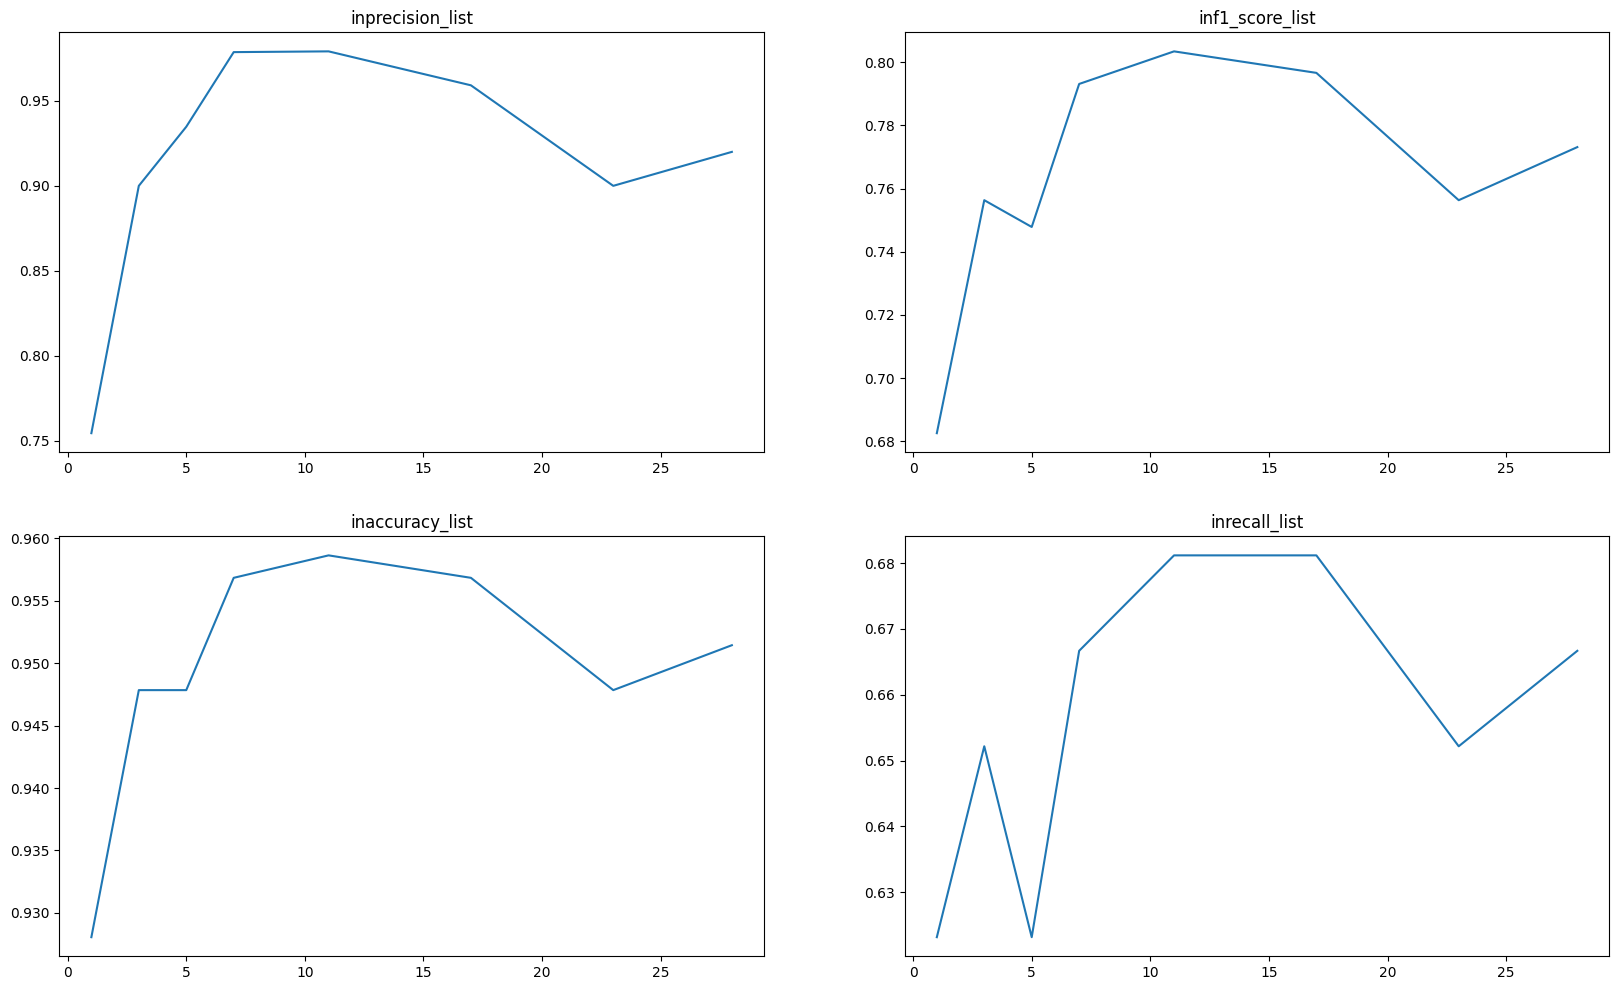

In [25]:
data = ['inprecision_list','inf1_score_list','inaccuracy_list','inrecall_list']
fig, axs = plt.subplots(2,2,figsize=[20,12])
for i in range(2):
    for j in range(2):
        axs[i][j].set_title(data[2*i+j])
        axs[i][j].plot(k,globals()[data[2*i+j]])
plt.show()

In [26]:
print(confusion_matrix(np.array(y_test).astype(float),np.array(iny_pred_list[2]).astype(float)))

[[451  42]
 [ 59   4]]


In [27]:
print("K : ",k,"\n")
print("precision_list : ",precision_list,"\n")
print("f1_score_list : ",f1_score_list,"\n")
print("accuracy_list : ",accuracy_list,"\n")
print("recall_list : ",recall_list,"\n")

K :  [1, 3, 5, 7, 11, 17, 23, 28] 

precision_list :  [0.7543859649122807, 0.9, 0.9347826086956522, 0.9787234042553191, 0.9791666666666666, 0.9591836734693877, 0.9, 0.92] 

f1_score_list :  [0.6825396825396826, 0.7563025210084033, 0.7478260869565218, 0.793103448275862, 0.8034188034188035, 0.7966101694915255, 0.7563025210084033, 0.7731092436974789] 

accuracy_list :  [0.9280575539568345, 0.947841726618705, 0.947841726618705, 0.9568345323741008, 0.9586330935251799, 0.9568345323741008, 0.947841726618705, 0.9514388489208633] 

recall_list :  [0.6231884057971014, 0.6521739130434783, 0.6231884057971014, 0.6666666666666666, 0.6811594202898551, 0.6811594202898551, 0.6521739130434783, 0.6666666666666666] 



In [28]:
k_best = np.argmax(np.array(accuracy_list))
print(f'Best K : {k_best}')
print(f'Best Accuracy : {accuracy_list[k_best]}')

Best K : 4
Best Accuracy : 0.9586330935251799


In [29]:
# Use Test dataset to check accuracy
y_pred = knn_predict(train_data_index,y_train,test_data_index,k_neighbour=k_best,matric='cosine')
print(accuracy_score(y_test,y_pred))

0.9370503597122302


***Compare both the models result.***

Both gave ***same*** results (if distance matrix choosen is same)

***What is the time complexity of training using KNN classifier?***

The Training time complexity is O(1)

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***

If there are n test cases then the time complexity is O(n).

KNN is not a linear classifier and hence can learn any linear boundary.